In [2]:
import numpy as np
import pandas as pd
import keras

In [3]:
df = pd.read_csv('IMDB Dataset.csv')

In [23]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [4]:
df.head().T

,0,1,2,3,4
review,One of the other reviewers has mentioned that ...,A wonderful little production. <br /><br />The...,I thought this was a wonderful way to spend ti...,Basically there's a family where a little boy ...,"Petter Mattei's ""Love in the Time of Money"" is..."
sentiment,positive,positive,positive,negative,positive


In [10]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer

#df['review_tokenized'] = df.apply(lambda row: text_to_word_sequence(df['review']), axis=1)
words = ' '.join(df['review'].tolist())
words = text_to_word_sequence(words)
#print(words)


tokenizer = Tokenizer()
tokenizer.fit_on_texts(words)
vocabulary_size = len(tokenizer.word_index) + 1
sequences = pd.Series(tokenizer.texts_to_sequences(df['review']))

In [52]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

n_words = 0

maxlen = 0

for seq in sequences:
    if len(seq) > maxlen:
        maxlen = len(seq)
    if max(seq) > n_words:
        n_words = max(seq)
    
n_words += 1
print('n_words: ',n_words)
print('max length: ',maxlen)


X = pad_sequences(sequences, maxlen=maxlen)

n_words:  124253
max length:  2493


In [53]:
#X = sequences
y = df['sentiment']

In [54]:
X = pd.DataFrame(X)

In [55]:
X

,0,1,2,3,4,5,6,7,8,9,...,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492
0,0,0,0,0,0,0,0,0,0,0,...,43,22,67,76,8,1228,16,125,4103,486
1,0,0,0,0,0,0,0,0,0,0,...,16,71840,48043,27894,170,2297,23,1977,69,221
2,0,0,0,0,0,0,0,0,0,0,...,71,2658,3,78,202,5,139,63,16,350
3,0,0,0,0,0,0,0,0,0,0,...,3303,14,15,1,644,16,3639,39,2775,93
4,0,0,0,0,0,0,0,0,0,0,...,11649,49,2051,2,11965,17118,15,24,365,158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,5978,56,2591,5,11,17,7,7,723,156
49996,0,0,0,0,0,0,0,0,0,0,...,209,126,91,103,671,1,3803,4,1,4450
49997,0,0,0,0,0,0,0,0,0,0,...,6,357,16,1957,10637,2,26347,22840,2,6050
49998,0,0,0,0,0,0,0,0,0,0,...,2237,17176,1,23729,12,11794,4209,67,739,42


In [20]:
y

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 50000, dtype: object

In [56]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

y = enc.fit_transform(y).astype(int)

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

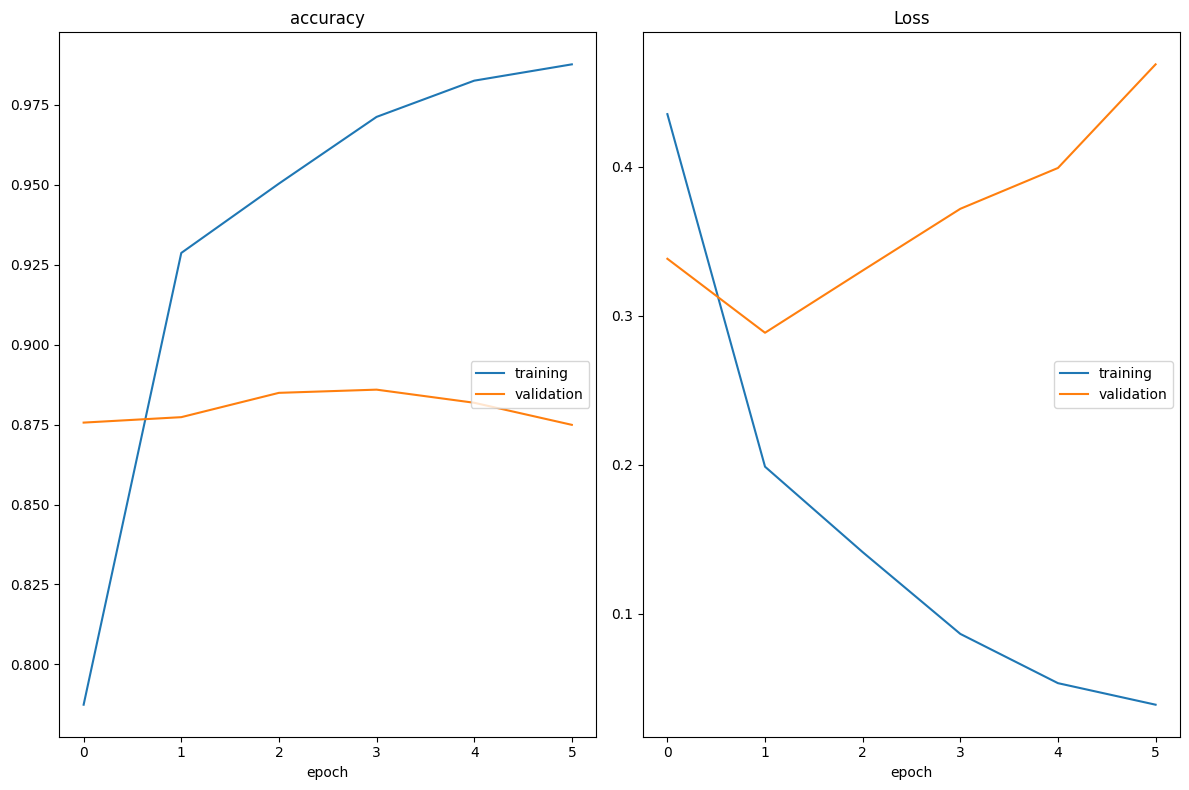

accuracy
	training         	 (min:    0.787, max:    0.988, cur:    0.988)
	validation       	 (min:    0.875, max:    0.886, cur:    0.875)
Loss
	training         	 (min:    0.039, max:    0.435, cur:    0.039)
	validation       	 (min:    0.289, max:    0.469, cur:    0.469)
157/157 ━━━━━━━━━━━━━━━━━━━━ 889s 6s/step - accuracy: 0.9902 - loss: 0.0325 - val_accuracy: 0.8749 - val_loss: 0.4689
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 182ms/step - accuracy: 0.8757 - loss: 0.4806
Final Test Accuracy: 0.8749


In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

from livelossplot import PlotLossesKeras
from tensorflow.keras import regularizers



learning_rate = 0.001
lstm_units = 64
dense_units = 32
dropout_rate = 0.2


model = Sequential()

model.add(Embedding(input_dim=n_words, output_dim=lstm_units))
model.add(LSTM(units=lstm_units, activation='tanh'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=dense_units, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=1, activation='sigmoid'))
          


# Early stopping callback
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=4,
        verbose=0,
        mode='auto'
    ),
    PlotLossesKeras()
]


optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=256, epochs=30, 
          validation_data =(X_test,y_test),
          callbacks=[PlotLossesKeras(),callbacks])



# Evaluate the final model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {accuracy:.4f}")

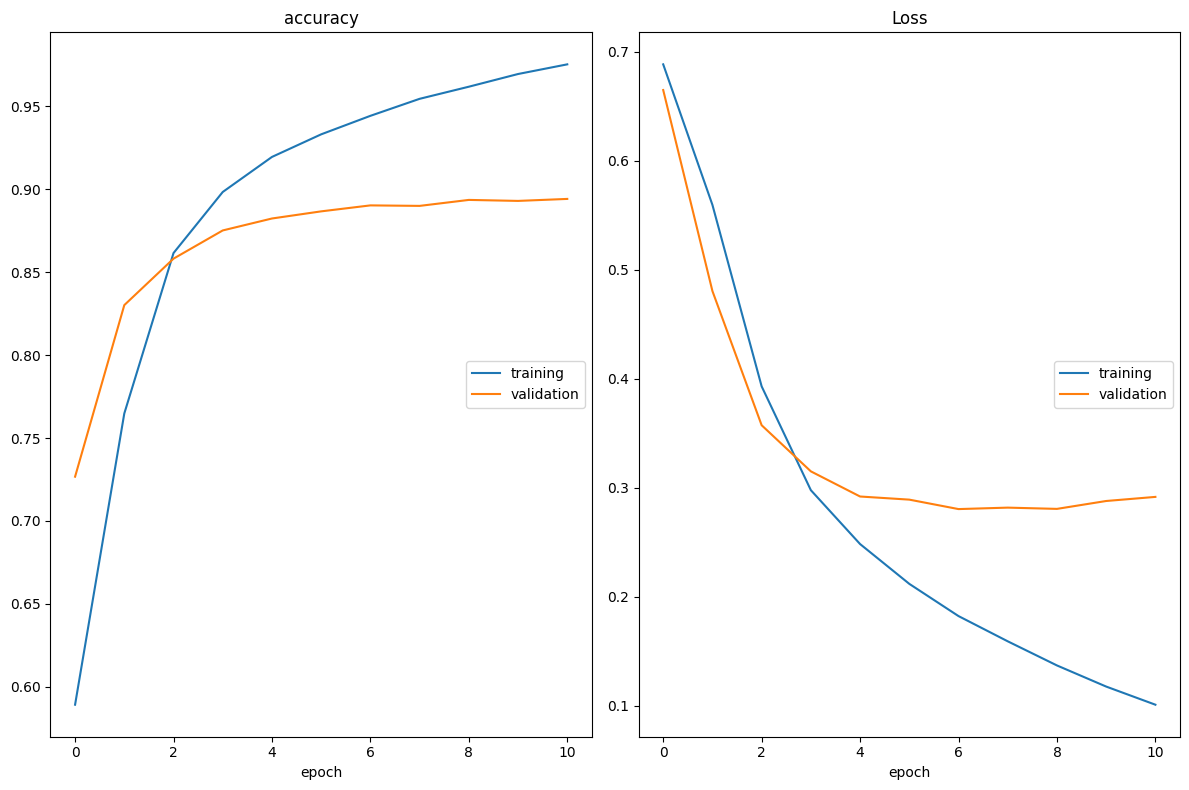

accuracy
	training         	 (min:    0.589, max:    0.975, cur:    0.975)
	validation       	 (min:    0.727, max:    0.894, cur:    0.894)
Loss
	training         	 (min:    0.101, max:    0.688, cur:    0.101)
	validation       	 (min:    0.280, max:    0.665, cur:    0.292)
157/157 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.9750 - loss: 0.1036 - val_accuracy: 0.8941 - val_loss: 0.2916
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step - accuracy: 0.8908 - loss: 0.3006
Final Test Accuracy: 0.8941


In [67]:
# Simpler model and a slower learning rate

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

from livelossplot import PlotLossesKeras
from tensorflow.keras import regularizers



learning_rate = 0.0001
lstm_units = 32
dense_units = 16
dropout_rate = 0.2


model = Sequential()

model.add(Embedding(input_dim=n_words, output_dim=lstm_units))
model.add(LSTM(units=lstm_units, activation='tanh'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=dense_units, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=1, activation='sigmoid'))
          


# Early stopping callback
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=4,
        verbose=0,
        mode='auto'
    ),
    PlotLossesKeras()
]


optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=256, epochs=30, 
          validation_data =(X_test,y_test),
          callbacks=[PlotLossesKeras(),callbacks])



# Evaluate the final model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {accuracy:.4f}")

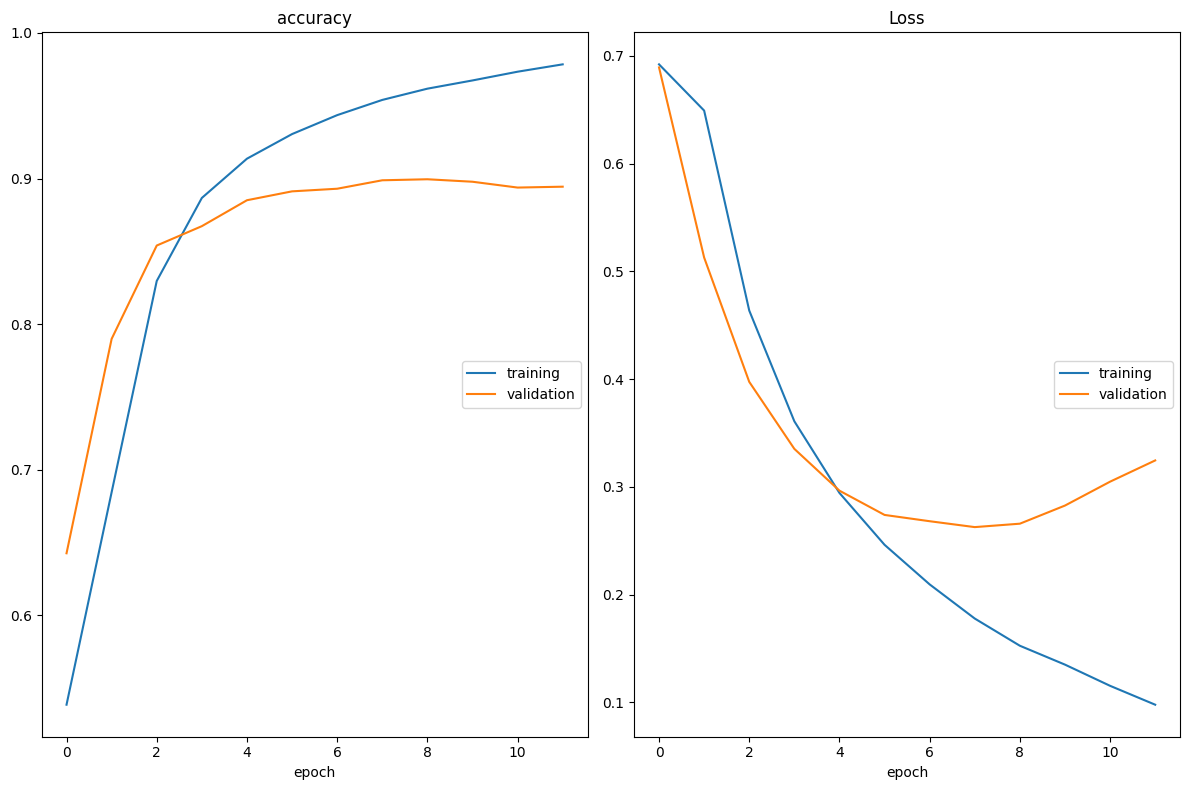

accuracy
	training         	 (min:    0.539, max:    0.978, cur:    0.978)
	validation       	 (min:    0.643, max:    0.900, cur:    0.894)
Loss
	training         	 (min:    0.098, max:    0.692, cur:    0.098)
	validation       	 (min:    0.263, max:    0.689, cur:    0.325)
157/157 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.9784 - loss: 0.0988 - val_accuracy: 0.8944 - val_loss: 0.3245
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.8903 - loss: 0.3355
Final Test Accuracy: 0.8944


In [68]:
# Higher dropout rate to reduce overfitting

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

from livelossplot import PlotLossesKeras
from tensorflow.keras import regularizers



learning_rate = 0.0001
lstm_units = 32
dense_units = 16
dropout_rate = 0.4


model = Sequential()

model.add(Embedding(input_dim=n_words, output_dim=lstm_units))
model.add(LSTM(units=lstm_units, activation='tanh'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=dense_units, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=1, activation='sigmoid'))
          


# Early stopping callback
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=4,
        verbose=0,
        mode='auto'
    ),
    PlotLossesKeras()
]


optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=256, epochs=30, 
          validation_data =(X_test,y_test),
          callbacks=[PlotLossesKeras(),callbacks])



# Evaluate the final model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {accuracy:.4f}")

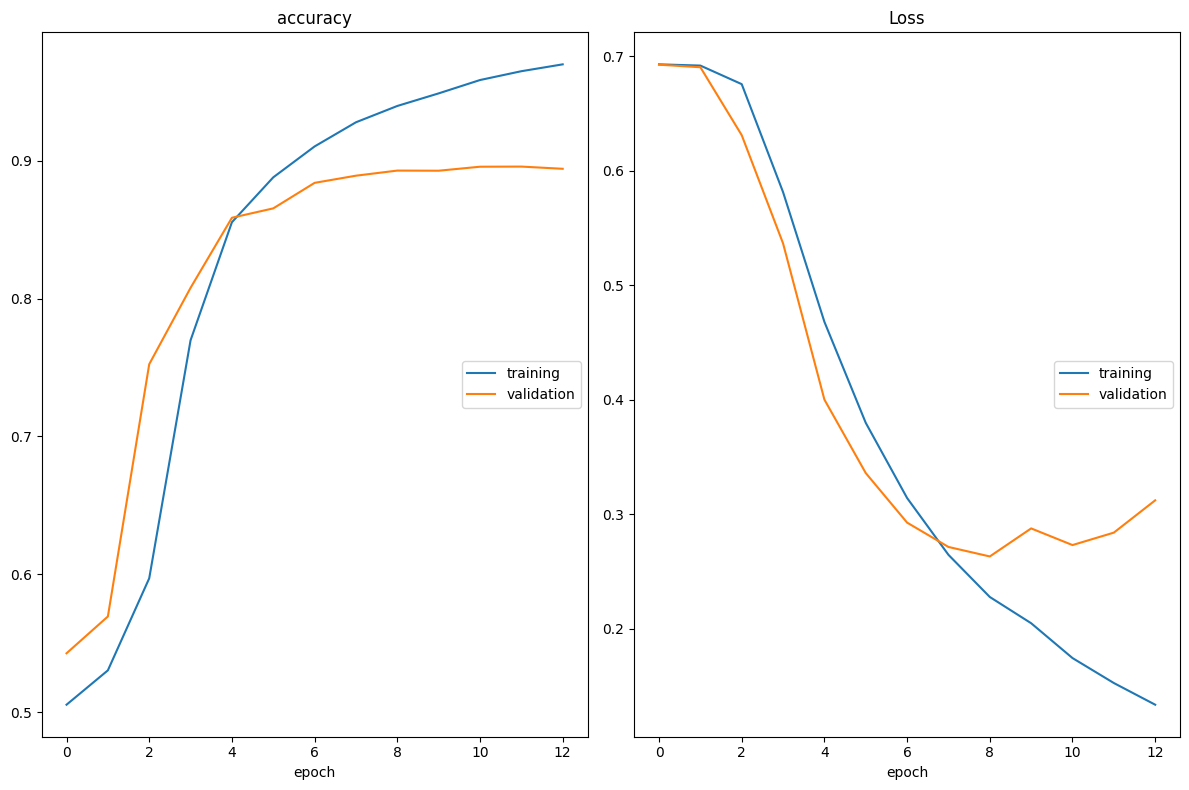

accuracy
	training         	 (min:    0.506, max:    0.970, cur:    0.970)
	validation       	 (min:    0.543, max:    0.896, cur:    0.894)
Loss
	training         	 (min:    0.134, max:    0.693, cur:    0.134)
	validation       	 (min:    0.263, max:    0.693, cur:    0.312)
157/157 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - accuracy: 0.9699 - loss: 0.1350 - val_accuracy: 0.8941 - val_loss: 0.3123
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.8899 - loss: 0.3300
Final Test Accuracy: 0.8941


In [69]:
# Even higher dropout rate to reduce overfitting

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

from livelossplot import PlotLossesKeras
from tensorflow.keras import regularizers



learning_rate = 0.0001
lstm_units = 32
dense_units = 16
dropout_rate = 0.6


model = Sequential()

model.add(Embedding(input_dim=n_words, output_dim=lstm_units))
model.add(LSTM(units=lstm_units, activation='tanh'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=dense_units, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=1, activation='sigmoid'))
          


# Early stopping callback
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=4,
        verbose=0,
        mode='auto'
    ),
    PlotLossesKeras()
]


optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=256, epochs=30, 
          validation_data =(X_test,y_test),
          callbacks=[PlotLossesKeras(),callbacks])



# Evaluate the final model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {accuracy:.4f}")

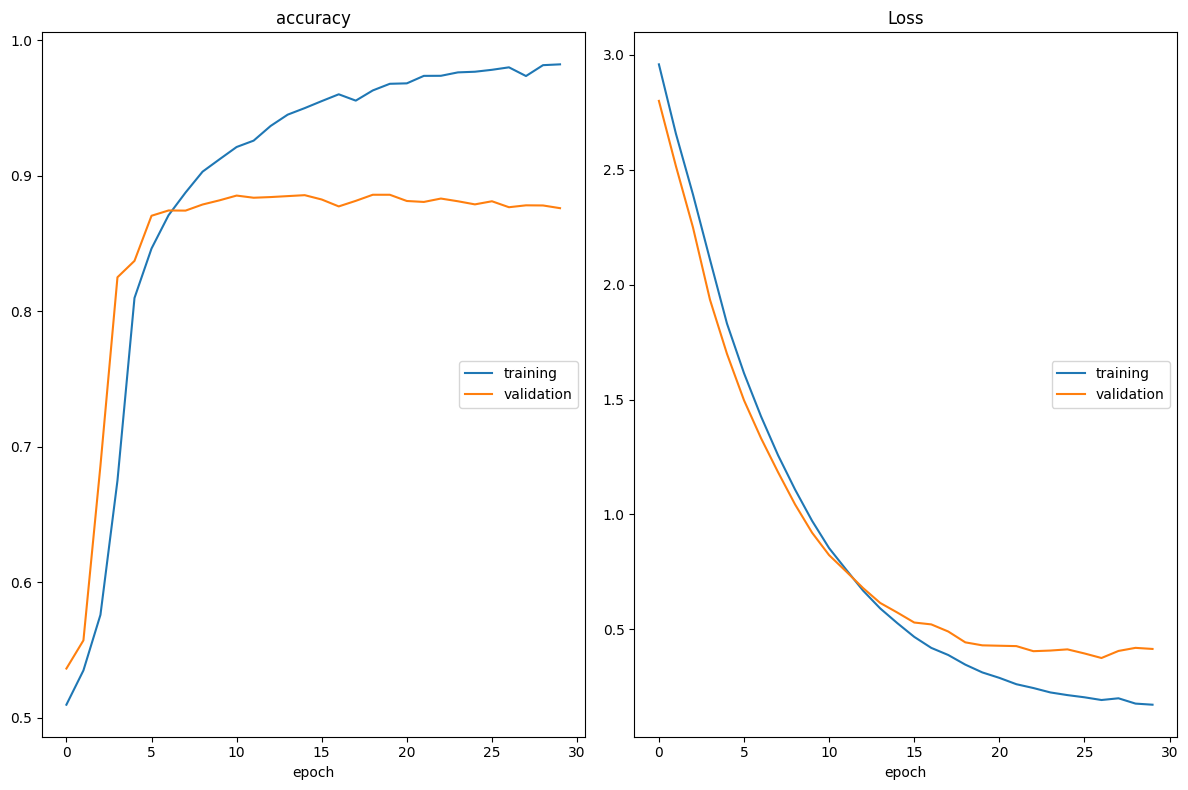

accuracy
	training         	 (min:    0.510, max:    0.982, cur:    0.982)
	validation       	 (min:    0.536, max:    0.886, cur:    0.876)
Loss
	training         	 (min:    0.172, max:    2.959, cur:    0.172)
	validation       	 (min:    0.375, max:    2.800, cur:    0.415)
157/157 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9813 - loss: 0.1779 - val_accuracy: 0.8762 - val_loss: 0.4149
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.8728 - loss: 0.4265
Final Test Accuracy: 0.8762


In [72]:
# And adding l2 regularization

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

from livelossplot import PlotLossesKeras
from tensorflow.keras import regularizers



learning_rate = 0.0001
lstm_units = 32
dense_units = 20
dropout_rate = 0.6
l2_reg = 0.1


model = Sequential()

model.add(Embedding(input_dim=n_words, output_dim=lstm_units))
model.add(LSTM(units=lstm_units, activation='tanh'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=dense_units, activation='relu',kernel_regularizer=regularizers.l2(l2_reg)))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=1, activation='sigmoid'))
          


# Early stopping callback
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=4,
        verbose=0,
        mode='auto'
    ),
    PlotLossesKeras()
]


optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=256, epochs=30, 
          validation_data =(X_test,y_test),
          callbacks=[PlotLossesKeras(),callbacks])



# Evaluate the final model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {accuracy:.4f}")